Script for estimating average R-squared and RMSE for 5-fold cross validation performed for regression (using curve fitting) for counties of Kansas

In [1]:
# Importing modules 
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

c:\python38\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [27]:
climateData_path = '/path/to/dir/ClimateData/'                    # Please provide folder location 

In [28]:
obsYld_path = '/path/to/dir/obs_yld/'                             # Please provide folder location

In [4]:
list_ppt = glob.glob(climateData_path+"/ppt/*.csv")

In [5]:
# Storing names of counties 
county = []
for i in range(len(list_ppt)):
    temp_name = list_ppt[i].split("\\")[-1][:-4]
    county.append(temp_name)

In [6]:
# Creating separate dataframes tmax, tmin, ppt and yld for all counties
df_tmax_all = pd.DataFrame([])
df_tmin_all = pd.DataFrame([])
df_ppt_all = pd.DataFrame([])
df_yld_all = pd.DataFrame([])
for i in range(len(county)):
    temp_tmax = pd.read_csv(climateData_path + 'tmax/'+ county[i]+ '.csv')
    temp_tmax = temp_tmax.set_index("date")
    
    temp_tmin = pd.read_csv(climateData_path + 'tmin/'+ county[i]+ '.csv')
    temp_tmin = temp_tmin.set_index("date")
    
    temp_ppt = pd.read_csv(climateData_path + 'ppt/'+ county[i]+ '.csv')
    temp_ppt = temp_ppt.set_index("date")

    temp_yld = pd.read_csv(obsYld_path +  str.upper(county[i])+ '.csv')
    temp_yld = temp_yld.set_index("Year")
    
    df_tmax_all = pd.concat([df_tmax_all, temp_tmax], axis = 1)
    df_tmin_all = pd.concat([df_tmin_all, temp_tmin], axis = 1)
    df_ppt_all = pd.concat([df_ppt_all, temp_ppt], axis = 1)
    df_yld_all = pd.concat([df_yld_all, temp_yld["Value"]], axis = 1)
    
df_tmax_all.columns = county
df_tmin_all.columns = county   
df_ppt_all.columns = county
df_yld_all.columns = county

df_tmax_all.index = pd.to_datetime(df_tmax_all.index)
df_tmin_all.index = pd.to_datetime(df_tmin_all.index)
df_ppt_all.index = pd.to_datetime(df_ppt_all.index)

In [7]:
df_tmax_all.head()

,Allen,Anderson,Atchison,Barber,Barton,Bourbon,Brown,Butler,Chase,Chautauqua,...,Sumner,Thomas,Trego,Wabaunsee,Wallace,Washington,Wichita,Wilson,Woodson,Wyandotte
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,14.015893,13.422222,11.460068,16.667333,15.148723,13.702725,10.669270,14.044533,13.039681,16.000856,...,15.312693,14.329412,14.917238,12.304977,15.224097,11.861629,14.93793,14.451682,14.025299,11.49555
1981-01-02,7.004120,6.632384,5.170424,9.951715,7.980269,7.227506,4.795899,6.851400,5.877534,8.777115,...,8.317089,7.439969,8.035867,5.552379,7.891922,6.882601,7.31082,7.061227,6.700623,5.86860
1981-01-03,9.210040,8.962202,8.022424,14.430538,15.772723,8.874088,7.779360,10.448129,9.911302,11.076990,...,11.788417,17.273575,14.690007,8.978508,16.773805,9.398252,15.44989,9.732523,9.694442,7.93805
1981-01-04,0.386867,-0.654556,-3.537424,1.812882,-1.885592,1.009286,-4.266270,-0.215071,-1.572302,2.450298,...,1.390505,5.191125,0.417727,-2.861182,5.351578,-2.627280,3.94174,0.619795,-0.150714,-2.92185
1981-01-05,-0.891693,-1.533111,-3.186475,4.172968,3.398308,-1.118747,-3.450809,-0.092796,-1.236302,1.185769,...,1.355318,12.208319,5.155769,-2.549765,12.725033,-2.310685,12.07499,-0.290170,-0.703221,-3.60535


In [8]:
# Selecting climate parameters only for the months from Apr to Sep

df_tmax_grow = df_tmax_all.loc[df_tmax_all.index.month.isin([4,5,6,7,8,9])]
df_tmin_grow = df_tmin_all.loc[df_tmin_all.index.month.isin([4,5,6,7,8,9])]
df_ppt_grow = df_ppt_all.loc[df_ppt_all.index.month.isin([4,5,6,7,8,9])]

In [9]:
df_tmax_grow_mean  = df_tmax_grow.mean(axis = 0)
df_tmax_grow_mean.name = "tmax_avg"
df_tmin_grow_mean  = df_tmin_grow.mean(axis = 0)
df_tmin_grow_mean.name = "tmin_avg"
df_yld_mean  = df_yld_all.mean(axis = 0)
df_yld_mean.name = "yld_avg"

In [10]:
# Reading the shapefiles of Kansas counties
kansas_shp = gpd.read_file("/path/to/dir/Kansas.shp")

In [11]:
kansas_shp.head(2)

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,...,FHH_OWNCHL,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,Shape_Leng,Shape_Area,geometry
0,20,071,00485002,20071,Greeley,Greeley County,H1,G4020,None,None,...,9.0,356.0,2.88,629.0,104.0,394.0,131.0,1.827838,0.208156,"POLYGON ((-101.79971 38.69806, -101.79097 38.6..."
1,20,059,00484998,20059,Franklin,Franklin County,H1,G4020,312,28140,...,671.0,6998.0,3.02,11147.0,1043.0,7184.0,2920.0,1.601719,0.154502,"POLYGON ((-95.40873 38.73888, -95.40817 38.738..."


In [12]:
kansas_shp = kansas_shp[["NAME10", "geometry"]]

In [13]:
# Merging mean tmax and tmin and yield dataseries to the shapefile

kansas_shp = kansas_shp.merge(df_tmax_grow_mean, left_on = "NAME10", right_index = True)
kansas_shp = kansas_shp.merge(df_tmin_grow_mean, left_on = "NAME10", right_index = True)
kansas_shp = kansas_shp.merge(df_yld_mean, left_on = "NAME10", right_index = True)

In [14]:
kansas_shp.head(2)

,NAME10,geometry,tmax_avg,tmin_avg,yld_avg
0,Greeley,"POLYGON ((-101.79971 38.69806, -101.79097 38.6...",27.659894,10.821280,59.016667
1,Franklin,"POLYGON ((-95.40873 38.73888, -95.40817 38.738...",26.929528,15.036578,111.957744


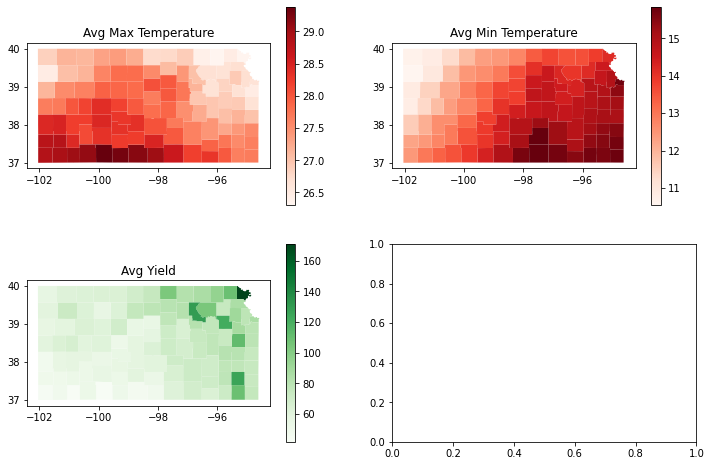

In [15]:
# Spatial plot of temperature and yield across the Kansas state
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
ax = ax.flatten()
kansas_shp.plot(column = 'tmax_avg', ax = ax[0], cmap ="Reds", legend = True)
kansas_shp.plot(column = 'tmin_avg', ax = ax[1], cmap ="Reds", legend = True)
kansas_shp.plot(column = 'yld_avg', ax = ax[2], cmap ="Greens", legend = True)
ax[0].set_title("Avg Max Temperature");
ax[1].set_title("Avg Min Temperature");
ax[2].set_title("Avg Yield");

In [16]:
'''
Calculating GDD and EDD for corn where GDD is growing degree days and EDD is extreme degree days
Developing function for them to calculate daily GDD and EDD.
'''

# GDD function having 2 argument daily maximum (x) and minimum (y) temperature 
def fun_GDD(x,y):
    temp = (x+y)/2 - 9
    if temp >= 0:
        return temp
    else:
        return 0

# EDD function having 1 argument daily maximum (x) temperature
def fun_EDD(x):
    temp = x-29
    if temp >= 0:
        return temp
    else:
        return 0


In [17]:
# Calculation of GDD and EDD for all counties for growing period
df_GDD = pd.DataFrame([])
df_EDD = pd.DataFrame([])
for i in range(len(county)):
    temp_tmax = df_tmax_grow[county[i]]
    temp_tmin = df_tmin_grow[county[i]]
    GDD = []
    EDD = []
    for j in range(len(temp_tmax)):
        temp_gdd = fun_GDD(temp_tmax.values[j], temp_tmin.values[j])
        temp_edd = fun_EDD(temp_tmax.values[j])
        GDD.append(temp_gdd)
        EDD.append(temp_edd)
    
    df_GDD = pd.concat([df_GDD, pd.DataFrame(GDD)], axis = 1)
    df_EDD = pd.concat([df_EDD, pd.DataFrame(EDD)], axis = 1)
    
df_GDD.columns = county
df_GDD.index = df_tmax_grow.index
df_EDD.columns = county
df_EDD.index = df_tmax_grow.index

In [18]:
df_GDD.head()

,Allen,Anderson,Atchison,Barber,Barton,Bourbon,Brown,Butler,Chase,Chautauqua,...,Sumner,Thomas,Trego,Wabaunsee,Wallace,Washington,Wichita,Wilson,Woodson,Wyandotte
date,,,,,,,,,,,,,,,,,,,,,
1981-04-01,3.816480,4.078500,3.954695,2.215492,1.934031,4.209813,3.443455,3.049080,3.127125,2.962433,...,2.736727,0.000000,0.048231,2.695186,0.000000,1.370217,0.000000,3.393102,3.594578,5.794150
1981-04-02,7.309260,7.475323,6.384729,6.908328,5.909658,7.157852,6.031826,6.525107,6.581539,7.278053,...,6.830529,3.404909,4.950836,6.212193,3.269558,6.508741,3.982405,7.349682,7.514513,7.518825
1981-04-03,12.322873,12.827222,13.450483,11.456344,11.739546,11.811148,13.271152,11.792053,12.645578,12.361577,...,11.732359,7.084050,9.940955,13.167746,7.505581,12.998899,8.581145,12.382454,12.655286,14.515975
1981-04-04,6.078107,5.837354,5.550856,5.317828,6.337127,6.534088,5.211590,5.453593,5.545591,6.287226,...,4.822091,0.175522,4.532462,5.420447,0.000000,5.525885,1.414965,5.829739,5.459084,6.608000
1981-04-05,0.000000,0.000000,0.000000,0.990914,0.355523,0.000000,0.000000,0.000000,0.000000,0.165327,...,0.718875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# Summing daily GDD, EDD and ppt for the years to get annual values

df_GDD_year = df_GDD.resample(rule="Y").sum()
df_EDD_year = df_EDD.resample(rule="Y").sum()
df_ppt_year = df_ppt_grow.resample(rule="Y").sum()

In [20]:
df_GDD_year.index = df_GDD_year.index.year
df_EDD_year.index = df_EDD_year.index.year
df_ppt_year.index = df_ppt_year.index.year

In [21]:
# Function for regression model function with 6 arguments (a0,a1,a2,a3,a4,a5) for 3 predictor variables
def fun_KS(x,a0,a1,a2,a3,a4,a5):
    y = a0 + a1*x[0] + a2*x[1] + a3*x[2] + a4*x[2]**2 + a5*x[2]*x[1]     # 3 predictor variables x[0], x[1], x[2] 
    return y

In [22]:
# Main script
# Empty list created to append each county R-squared and RMSE data at later stage
df_r2_rmse = pd.DataFrame([])

# Loop for automation of the  regression model for all selected counties of Kansas 
for i in range(len(county)):

    """
    Read the county-wise .csv file having time series data of predictor (GDD, EDD & ppt) and response variables (Corn yield)
    then predictor and response variables were saved in X and y
    """
    print("Running for the county: ", county[i])
    county_r2 =[]
    county_rmse =[]
    # Extracting the predictors and response variables, and save them in X and y
    df = pd.concat([df_GDD_year[county[i]], df_EDD_year[county[i]], df_ppt_year[county[i]], df_yld_all[county[i]]], axis = 1) 
    df.columns = ["GDD", "EDD", "ppt", "Yield"]
    df = df.dropna()
    
    if len(df)>=30:  # Only selecting counties with data greater than 30 years 
        y = df[["Yield"]]                   # Response variable - Corn yield
        X = df[["GDD", "EDD", "ppt"]]   # Predictor variables - GDD, EDD, ppt


        # By using the Kfold cross-validation function, split the data into 5 parts (n_splits=5)
        kf = KFold(n_splits=5)


        # Empty list created to append the values of R-squared and RMSE from each fold (5-fold) in a county
        rmse_test_all = []
        r2_test_all = []

        """
        The approach involves dividing the data into training and testing sets using a loop, where four parts are used for training
        and the remaining part is used for testing. Curve fitting were used to fit the model, and both the training and testing yields 
        were calculated and and performance metrics such as R-squared and RMSE are used to evaluate the model's performance
        """    
        for train, test in kf.split(X):

            # Splitting the data into training and testing sets
            X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test],y.iloc[train], y.iloc[test]

            # Fitting data using curve_fit function of scipy and it returns optimal parameters/coefficient (p), and estimated covariance (c) values         
            p, c = curve_fit(fun_KS, [X_train["GDD"],X_train["EDD"],X_train["ppt"]],y_train["Yield"])

            # Predicting the yield for training set and saving as mod_yld_train (model predicted yield from training)
            mod_yld_train = fun_KS([X_train["GDD"].values,X_train["EDD"].values,X_train["ppt"].values],
                                    p[0],p[1],p[2],p[3],p[4],p[5])

            # Predicting the yield from testing set and saving as mod_yld_test (model predicted yield from testing)
            mod_yld_test = fun_KS([X_test["GDD"].values,X_test["EDD"].values,X_test["ppt"].values],
                                   p[0],p[1],p[2],p[3],p[4],p[5])

            # Calculating performance metrices (R-squared and RMSE) for predicted yield of testing set
            r2_test = r2_score(y_test,mod_yld_test)
            rmse_test = mean_squared_error(y_test,mod_yld_test, squared=False)

            # Appending R-squared and RMSE in the empty list for each fold (5-fold) in a county
            r2_test_all.append(r2_test)        
            rmse_test_all.append(rmse_test)

        # Calculating mean of the R-squared and RMSE 
        county_r2.append(np.mean(r2_test_all))
        county_rmse.append(np.mean(rmse_test_all))

        temp = [county[i], np.mean(r2_test_all), np.mean(rmse_test_all)]
        df_r2_rmse = pd.concat([df_r2_rmse, pd.DataFrame(temp).T])
    
    else:
        print("County: ", county[i], "does not have sufficient yield data")
        
        
df_r2_rmse.columns = ["County", "R2", "RMSE"]
df_r2_rmse = df_r2_rmse.reset_index(drop = True)

Running for the county:  Allen
County:  Allen does not have sufficient yield data
Running for the county:  Anderson
County:  Anderson does not have sufficient yield data
Running for the county:  Atchison
County:  Atchison does not have sufficient yield data
Running for the county:  Barber
County:  Barber does not have sufficient yield data
Running for the county:  Barton
County:  Barton does not have sufficient yield data
Running for the county:  Bourbon
County:  Bourbon does not have sufficient yield data
Running for the county:  Brown
County:  Brown does not have sufficient yield data
Running for the county:  Butler
County:  Butler does not have sufficient yield data
Running for the county:  Chase
County:  Chase does not have sufficient yield data
Running for the county:  Chautauqua
County:  Chautauqua does not have sufficient yield data
Running for the county:  Cherokee
County:  Cherokee does not have sufficient yield data
Running for the county:  Cheyenne
Running for the county:  C

In [23]:
df_r2_rmse.dtypes

County    object
R2        object
RMSE      object
dtype: object

In [24]:
# Converting R2 and RMSE data types

df_r2_rmse["R2"] = pd.to_numeric(df_r2_rmse["R2"])
df_r2_rmse["RMSE"] = pd.to_numeric(df_r2_rmse["RMSE"])

In [25]:
kansas_shp1 = kansas_shp.merge(df_r2_rmse, left_on = "NAME10", right_on = "County")
kansas_shp1.head()

,NAME10,geometry,tmax_avg,tmin_avg,yld_avg,County,R2,RMSE
0,Franklin,"POLYGON ((-95.40873 38.73888, -95.40817 38.738...",26.929528,15.036578,111.957744,Franklin,0.308766,28.216734
1,Clay,"POLYGON ((-97.37070 39.21899, -97.37067 39.221...",27.419465,14.554594,82.070968,Clay,-0.788637,24.120495
2,Republic,"POLYGON ((-97.93342 39.82744, -97.93342 39.827...",26.765989,13.391304,103.466756,Republic,-4.861493,63.282705
3,Doniphan,"POLYGON ((-95.33983 39.82762, -95.33986 39.835...",26.325732,14.167951,170.952001,Doniphan,-0.457593,37.782246
4,Ellis,"POLYGON ((-99.20947 38.69695, -99.21100 38.696...",27.881611,13.252634,68.817255,Ellis,-3.659521,48.166970


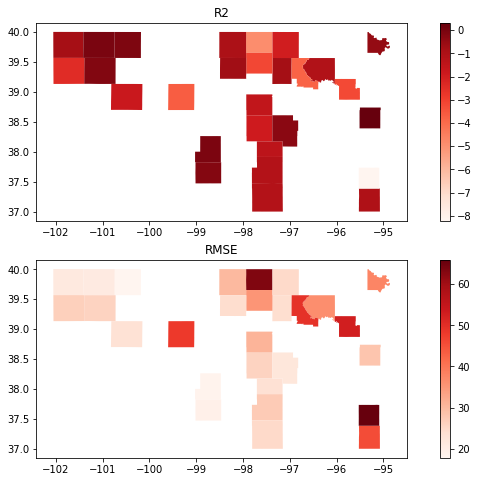

In [26]:
# Spatial plots of R2 and RMSE across Kansas

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8))
ax = ax.flatten()
kansas_shp1.plot(column = 'R2', ax = ax[0], cmap ="Reds", legend = True)
kansas_shp1.plot(column = 'RMSE', ax = ax[1], cmap ="Reds", legend = True)

ax[0].set_title("R2");
ax[1].set_title("RMSE");